In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from IPython.display import display
import matplotlib.pyplot as plt
from datasets import load_dataset
from dataset import get_elements_from_indexes, TRAIN_DATASET
from segmentation.k_means import kmeans, KmeansFlags, KmeansTermCrit, KmeansTermOpt
import numpy as np

In [3]:
def show_grayscale_image(image):
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.show()
    

In [4]:
dataset_dic = load_dataset(**TRAIN_DATASET)

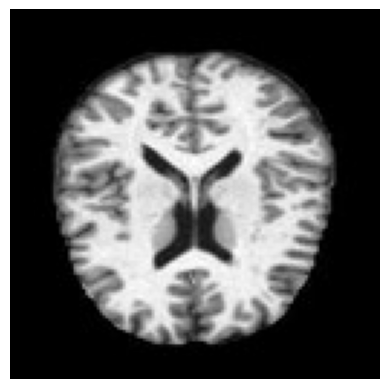

In [80]:
random_index = np.random.randint(len(dataset_dic))
element = get_elements_from_indexes(dataset_dic, random_index)[0]
image = element[0]
show_grayscale_image(image)

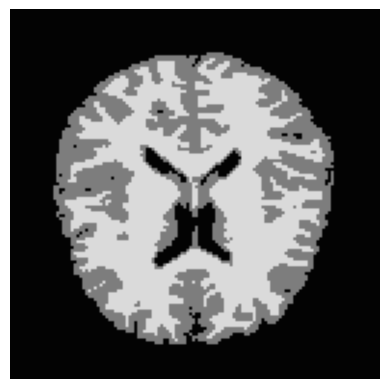

In [81]:
compactness, labels, centers = kmeans(image.flatten(), 3, criteria=KmeansTermCrit(KmeansTermOpt.BOTH, 20, 0.5), flags=KmeansFlags.KMEANS_PP_CENTERS)
centers = centers.astype(np.uint8)
segmented_kmeans = centers[labels].reshape(image.shape)
show_grayscale_image(segmented_kmeans)

In [82]:
sorted_centers = sorted(centers)
background_idx = np.argmax(centers == sorted_centers[0])
grey_matter_idx = np.argmax(centers == sorted_centers[1])
white_matter_idx = np.argmax(centers == sorted_centers[2])

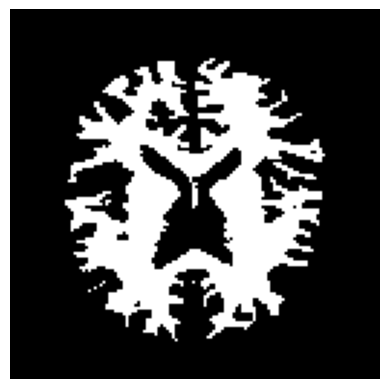

In [83]:
segmented_white_matter = np.where(segmented_kmeans == centers[white_matter_idx], 1, 0)
show_grayscale_image(segmented_white_matter * 255)

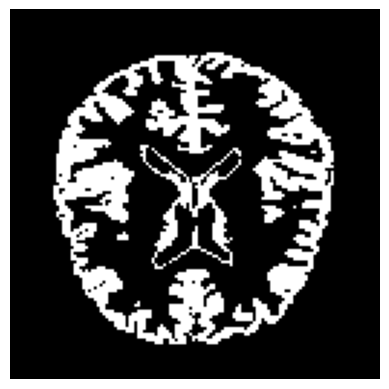

In [84]:
segmented_grey_matter = np.where(segmented_kmeans == centers[grey_matter_idx], 1, 0)
show_grayscale_image(segmented_grey_matter * 255)

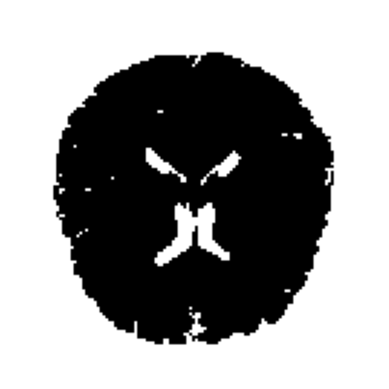

In [85]:
segmented_background = np.where(segmented_kmeans == centers[background_idx], 1, 0)
show_grayscale_image(segmented_background * 255)